# Load the Data

The class labels `"1"` for images containing cactus and `"0"` for others.

To submit to Kaggle, you need to generate a Kaggle submission files, which is CSV file with the following format. `'id'` is the file name of the input image: 

<pre>
Id,Prediction
cactus_0181_18.jpg,1
Sinplanta.4365.jpg,0
...
</pre>

Here are two helpful functions for reading the data and writing the Kaggle submission file.

In [1]:
%matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
from glob import glob
from scipy import stats
import csv
import os
random.seed(100)

In [15]:
def read_train_data():
    cactus_imgs = glob("training_set/training_set/cactus/*")
    cactus_labels = ones(len(cactus_imgs), dtype=int)
    nocactus_imgs = glob("training_set/training_set/no_cactus/*")
    nocactus_labels = zeros(len(nocactus_imgs), dtype=int)

    train_X = cactus_imgs + nocactus_imgs
    train_Y = hstack((cactus_labels, nocactus_labels))
    return train_X, train_Y

def read_test_data():
    cactus_imgs = glob("validation_set/validation_set/cactus/*")
    cactus_labels = ones(len(cactus_imgs), dtype=int)
    nocactus_imgs = glob("validation_set/validation_set/no_cactus/*")
    nocactus_labels = zeros(len(nocactus_imgs), dtype=int)

    test_X = cactus_imgs + nocactus_imgs
    test_Y = hstack((cactus_labels, nocactus_labels))
    return test_X, test_Y

def write_csv_kaggle_sub(fname, X, Y):
    # fname = file name
    # X is a list with image names
    # Y is a list/array with class entries
    
    # header
    tmp = [['Id', 'Prediction']]
    
    # add ID numbers for each Y
    for x,y in zip(X, Y):
        tmp2 = [x, y]
        tmp.append(tmp2)
        
    # write CSV file
    with open(fname, 'w') as f:
        writer = csv.writer(f)
        writer.writerows(tmp)

In [17]:
train_X, train_Y = read_train_data()
print(train_X[0], train_Y[0])
print(train_X[15000], train_Y[15000])

test_X, test_Y = read_test_data()
print(len(test_X))
print(os.path.basename(test_X[0]))

training_set/training_set/cactus\cactus_0028_0.jpg 1
training_set/training_set/no_cactus\Sinplanta.2677.jpg 0
4000
cactus_0181_18.jpg


# Methodology

The first step is to seperate whole training dataset into two parts - training set and validation set. We are using 90% of the whole training data for training and 10% for validation.

In [35]:
trainX, valX, trainY, valY = \
  model_selection.train_test_split(train_X, train_Y, 
  train_size=0.90, test_size=0.10)

Next, we are going to define hyper parameters.

In [64]:
# Hyper parameters

num_epochs = 30
num_classes = 2
batch_size = 25
learning_rate = 0.002

Then, we have to define our torch dataset class for getting images and data. In the getitem function, we have to preprocess our image so that all of our images have the same size. We resize the image to 3\*32\*32 pixels and turn them into vectors. 

In [65]:
import cv2
import torch
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, label, transform=None):
        super().__init__()
        self.data = data
        self.label = label
        self.transform = transform

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        img_name = self.data[index]
        label = self.label[index]
        image = plt.imread(img_name)
        image = cv2.resize(image, (32, 32),  
               interpolation = cv2.INTER_CUBIC) 
        image = self.transform(image)
        return image, label

trainDataset = Dataset(data=trainX, label=trainY, transform=transforms.ToTensor())
valDataset = Dataset(data=valX, label=valY, transform=transforms.ToTensor())
testDataset = Dataset(data=test_X, label=test_Y, transform=transforms.ToTensor())

We use GPU for calculations. This makes the computation time much shorter.

In [66]:
torch.cuda.is_available()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In the below code, we define loaders for training and validation respectively.

In [67]:
loader_train = DataLoader(dataset = trainDataset, 
                          batch_size=batch_size, 
                          shuffle=True,
                          num_workers=0)

loader_valid = DataLoader(dataset = valDataset,
                          batch_size=batch_size//2, 
                          shuffle=False, 
                          num_workers=0)

loader_test = DataLoader(dataset = testDataset, batch_size = batch_size, shuffle=False, num_workers=0)

After that, we are going to define a CNN network for training. I use two conv layer in the CNN. Each conv layer is followed by a max_pool2d and relu function. 
In the first conv layer, I use 3 as the in channels for rgb. I use 3 as the kernel size and 10 as the out channels.
For the second conv layer, I use 10 as the in channels which is same as the out channels in the first conv layer. I use a Dropout2d to avoid overfitting.
Then, I use two linear layers and finally I convert them in to a number as I only want to get a binary result, one number will be enough for it.

In [68]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module): 
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3)
        self.conv2 = nn.Conv2d(6, 18, kernel_size=3)
        self.fc1 = nn.Linear(648, 648*2)
        self.fc2 = nn.Linear(648*2, 1)
        self.drop = nn.Dropout2d()

    def forward(self, t):
        # conv layer 1
        t = self.conv1(t)
        t = F.max_pool2d(t, 2)
        t = F.relu(t)
        
        # conv layer 2
        t = self.conv2(t)
        t = self.drop(t)
        t = F.max_pool2d(t, 2)
        t = F.relu(t)
        
        t = t.view(t.shape[0],-1)
        t = F.relu(self.fc1(t))
        t = F.dropout(t, training=self.training)
        t = self.fc2(t)
        
        return t


Then, we are going to define the loss function and optimizer. I use BCEWithLogitsLoss as it is a binary classifier. I also use Adamax for optimizer.

In [69]:
model = CNN()
model = model.to(device)
# Loss function and optimizer
loss_func = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate)

Now, we are going to train the model. We also include evalulation in the loop.

In [70]:
total_step = len(loader_train)
train_losses = []
valid_losses = []
for epoch in range(num_epochs):
    train_loss = 0.0
    valid_loss = 0.0
    for i, batch in enumerate(loader_train):
        images = batch[0].to(device)
        labels = batch[1].unsqueeze(1).to(device)
        # Forward pass
        outputs = model(images)
        loss = loss_func(outputs, labels.float())
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        
    # validate-the-model
    model.eval()
    for i, batch in enumerate(loader_valid):
        
        images = batch[0].to(device)
        labels = batch[1].unsqueeze(1).to(device)
        
        outputs = model(images)
        
        loss = loss_func(outputs.float(), labels.float())
        
        # update-average-validation-loss 
        valid_loss += loss.item() * images.size(0)
    
    # calculate-average-losses
    train_loss = train_loss/len(loader_train.sampler)
    valid_loss = valid_loss/len(loader_valid.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    # print-training/validation-statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

Epoch: 0 	Training Loss: 0.320757 	Validation Loss: 0.195078
Epoch: 1 	Training Loss: 0.146815 	Validation Loss: 0.130788
Epoch: 2 	Training Loss: 0.125727 	Validation Loss: 0.102409
Epoch: 3 	Training Loss: 0.110460 	Validation Loss: 0.091873
Epoch: 4 	Training Loss: 0.100870 	Validation Loss: 0.158097
Epoch: 5 	Training Loss: 0.087346 	Validation Loss: 0.085869
Epoch: 6 	Training Loss: 0.078061 	Validation Loss: 0.093615
Epoch: 7 	Training Loss: 0.071787 	Validation Loss: 0.061548
Epoch: 8 	Training Loss: 0.059404 	Validation Loss: 0.054602
Epoch: 9 	Training Loss: 0.053274 	Validation Loss: 0.052531
Epoch: 10 	Training Loss: 0.045736 	Validation Loss: 0.062700
Epoch: 11 	Training Loss: 0.038387 	Validation Loss: 0.039124
Epoch: 12 	Training Loss: 0.030695 	Validation Loss: 0.036350
Epoch: 13 	Training Loss: 0.026405 	Validation Loss: 0.032271
Epoch: 14 	Training Loss: 0.019394 	Validation Loss: 0.047483
Epoch: 15 	Training Loss: 0.016550 	Validation Loss: 0.047170
Epoch: 16 	Trainin

We are going to evaluate the network by calculating the accuracy in the validation set. We get the result in 99.3142%, which is high, and we are satisfied with it.

In [71]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in loader_valid:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        outputs = outputs.cpu().detach().numpy()[:,0]
        labels = labels.cpu().detach().numpy()
        total += len(labels)
        for i, output in enumerate(outputs):
            if(output>0.5):
                pred=1
            else:
                pred=0
            if(pred== labels[i]):
                correct+=1

    print('Test Accuracy of the model on the {} validation images: {} %'.format(total, 100 * correct / total))

Test Accuracy of the model on the 1750 validation images: 99.37142857142857 %


We also analysis the relation between epochs and training and validation loss. As the below graph shown that the training and validation loss are decreasing rapidly when the epochs increases. We can conclude that the model is robust and there are little underfitting and overfitting.

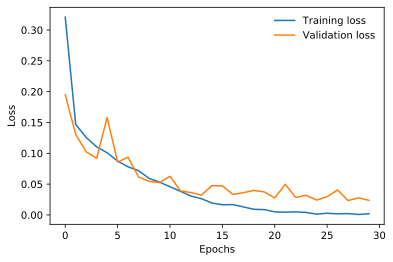

In [72]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(frameon=False)

In [73]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in loader_test:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        outputs = outputs.cpu().detach().numpy()[:,0]
        labels = labels.cpu().detach().numpy()
        total += len(labels)
        for i, output in enumerate(outputs):
            if(output>0.5):
                pred=1
            else:
                pred=0
            if(pred== labels[i]):
                correct+=1

    print('Test Accuracy of the model on the {} test images: {} %'.format(total, 100 * correct / total))

Test Accuracy of the model on the 4000 test images: 94.425 %


The final steps will be writing the test set result to csv file

In [74]:
# write your predictions on the test set
pred_list = []

for images, labels in loader_test:
        images = images.to(device)
        outputs = model(images)
        outputs = outputs.cpu().detach().numpy()[:,0]
        for i, output in enumerate(outputs):
            if(output>0):
                pred=1
            else:
                pred=0
            pred_list.append(pred)

dummy_test_X = [os.path.basename(x) for x in test_X]
test_Y = pred_list

write_csv_kaggle_sub("my_submission.csv", dummy_test_X, test_Y)